# COVID-19 Spread Toy Example
## Initilization Anchored NN Ensemble Sanity Check


In this notebook I want to demonstrate that my tensorflow implementation of the ensemble neural network is actually working and useful. In the spirit of times, I will try to learn the _hypothetical_ spreading of the COVID-19 disease in the _hypothetical_ island of Wakanda through the period of one year.

In [1]:
from simba.infrastructure import MLPEnsemble
import tensorflow as tf
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

/home/yardenas/anaconda3/envs/rl/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/yardenas/anaconda3/envs/rl/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/yardenas/anaconda3/envs/rl/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/yardenas/anaconda3/envs/rl/lib/python3.6/site-

First we generate some data using the [SIR model](https://www.lewuathe.com/covid-19-dynamics-with-sir-model.html) of covid19: 

In [2]:
def generate_covid_19_infection_rate_data():
    # https://www.lewuathe.com/covid-19-dynamics-with-sir-model.html
    # https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/
    population = 15000
    days = 365
    i_0, r_0 = 2, 0
    s_0 = population - i_0 - r_0
    beta, gamma = 0.3, 0.02
    t = np.linspace(0, days, days)

    def deriv(y, t, population, beta, gamma):
        S, I, R = y
        dSdt = -beta * S * I / population
        dIdt = beta * S * I / population - gamma * I
        dRdt = gamma * I
        return dSdt, dIdt, dRdt
    y_0 = s_0, i_0, r_0
    ret = odeint(deriv, y_0, t, args=(population, beta, gamma))
    _, infected_people, _ = ret.transpose()
    return t, infected_people

Say we have only have access to noisy measurements of how many people were sick on a certain day: 

In [10]:
time, infected_people = generate_covid_19_infection_rate_data()
n_samples = 2
noise = 0.1
inputs = np.array([])
targets = np.array([])
for day, sick_people_that_day in zip(time, infected_people):
    inputs = np.append(inputs, np.full(n_samples, day))
    targets = np.append(targets, np.random.normal(
    sick_people_that_day, noise * sick_people_that_day, n_samples))

In [11]:
# Some hyperparameters
def make_model(sess):
    mlp_dict = dict(
        input_dim=1,
        targets_dim=1,
        learning_rate=0.05,
        n_layers=2,
        hidden_size=128,
        activation=tf.nn.relu,
        anchor=True,
        init_std_bias=0.5,
        init_std_weights=3.5,
        data_noise=0.1
    )
    return MLPEnsemble(
        sess=sess,
        ensemble_size=5,
        n_epochs=1000,
        batch_size=128,
        **mlp_dict
    )

Run the training loop:

In [12]:
tf.reset_default_graph()

In [ ]:
n_particles = 20
x_val = np.tile(time, n_particles)
data_mean = inputs.mean()
data_std = inputs.std()
x = (inputs - data_mean) / (data_std + 1e-8)
with tf.Session() as sess:
    model = make_model(sess)
    sess.run(tf.global_variables_initializer())
    losses = model.fit(x[:, np.newaxis], targets[:, np.newaxis])
    pred = np.squeeze(model.predict(
        (x_val[:, np.newaxis] - data_mean) / (data_std + 1e-8)))

Epoch  0  | Losses = [596907.8, 684451.4, 425844.75, 483130.88, 551268.06]
Epoch  20  | Losses = [21166.525, 98089.18, 12561.122, 17898.791, 12175.248]
Epoch  40  | Losses = [8386.557, 41777.805, 6823.042, 7915.221, 5314.8594]
Epoch  60  | Losses = [3087.9614, 28244.33, 4428.763, 2324.911, 3353.6094]
Epoch  80  | Losses = [1278.0028, 16531.93, 1209.8872, 2990.516, 2430.4639]
Epoch  100  | Losses = [1212.7412, 11547.231, 1166.8289, 2254.9507, 352.66684]
Epoch  120  | Losses = [581.52673, 8753.883, 425.12756, 1413.2417, 510.25946]
Epoch  140  | Losses = [435.05405, 9112.284, 502.5826, 730.7996, 333.42737]
Epoch  160  | Losses = [286.12128, 6875.1494, 292.45914, 942.19653, 345.57086]
Epoch  180  | Losses = [303.01096, 6287.986, 252.7049, 382.0194, 267.1323]
Epoch  200  | Losses = [194.17772, 3870.787, 294.01022, 354.65036, 225.22566]
Epoch  220  | Losses = [160.64412, 3848.7646, 233.94707, 168.66647, 208.85698]
Epoch  240  | Losses = [350.08585, 2927.9539, 185.94951, 135.62776, 199.86783]

Reshaping back to (ensemble_size, n_particles, 365days). n_samples will help estimating aleatoric uncertainty and ensemble_size will help estimating epistemic uncertainty.

In [7]:
pred = np.reshape(pred, 
                  (model.ensemble_size, n_particles, time.shape[0]))
# For more details on decomposition of uncertainties: http://proceedings.mlr.press/v80/depeweg18a/depeweg18a.pdf 
aleatoric_uncertainty = np.mean(np.std(pred, axis=1) ** 2, axis=0)
epistemic_uncertainty = np.std(np.mean(pred, axis=1), axis=0) ** 2

Do some plotting

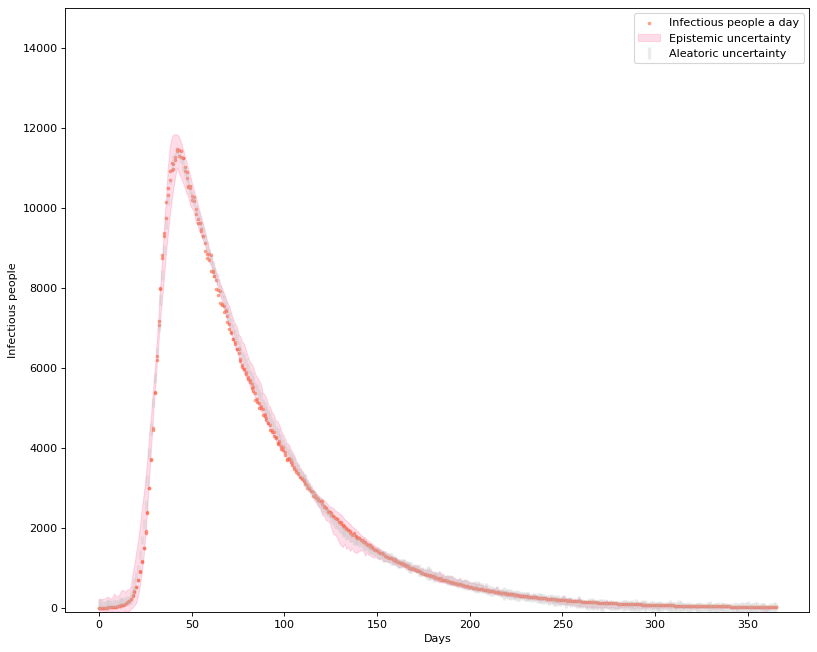

In [9]:
fig = plt.figure(figsize=(12, 10), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.subplots()
ax.set_ylim([-100, 15e3])
ax.scatter(inputs, targets, color='#FF764D', alpha=0.6,
           s=5, label='Infectious people a day')
# for mlp in range(model.ensemble_size):
#     ax.plot(time, np.mean(pred[mlp], axis=0), '-', color='#C20093', linewidth=1, label='Predictions')
ax.fill_between(time, np.mean(pred, axis=(0, 1)) - np.sqrt(epistemic_uncertainty),
                np.mean(pred, axis=(0, 1)) + np.sqrt(epistemic_uncertainty),
                color='#FC206C', alpha=0.15, label='Epistemic uncertainty')
ax.errorbar(time, np.mean(pred, axis=(0, 1)), yerr=np.sqrt(aleatoric_uncertainty), linewidth=0.0,
             ecolor='silver', elinewidth=3, capsize=0.0, label='Aleatoric uncertainty', alpha=0.3)
legend = ax.legend(loc='upper right', fontsize='medium')
plt.xlabel("Days")
plt.ylabel("Infectious people")
plt.show()